In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor



In [2]:
# load data
data = pd.read_csv('case1Data.csv')
y = data['y']
X = data.drop('y', axis=1)

# remove categorical variables and one hot encode them
cats = ["C_01","C_02","C_03","C_04","C_05"]
cat_variables = X[cats]
cat_nans_locs = cat_variables.isna()
cat_nans_locs = cat_nans_locs.any(axis=1)

cat_variables = pd.get_dummies(cat_variables, columns=cats, drop_first=False,dtype=int)
cat_variables["C_02_71.0"] = 0
cat_variables["C_02_73.0"] = 0
cat_variables["C_02_74.0"] = 0
cat_variables["C_02_75.0"] = 0
cat_variables = cat_variables.reindex(sorted(cat_variables.columns), axis=1) 
cat_variables.loc[cat_nans_locs] = np.nan
X = X.drop(cats, axis=1)
# to numpy
y = y.to_numpy()
X = X.to_numpy()
cat_variables = cat_variables.to_numpy()

X_standardizer = StandardScaler()
X_stand = X_standardizer.fit_transform(X)

X_merged = np.concatenate((X, cat_variables), axis=1)
# x_merged_seqred = np.concatenate([np.ones((X_merged.shape[0],1)),X_merged,np.square(X_merged)],axis=1)
# X_merged_sqrt = np.concatenate([np.ones((X_merged.shape[0],1)),X_merged,np.sqrt(X_merged)],axis=1)

X_merged_stand = np.concatenate((X_stand, cat_variables), axis=1)


Number of missing values: 1379


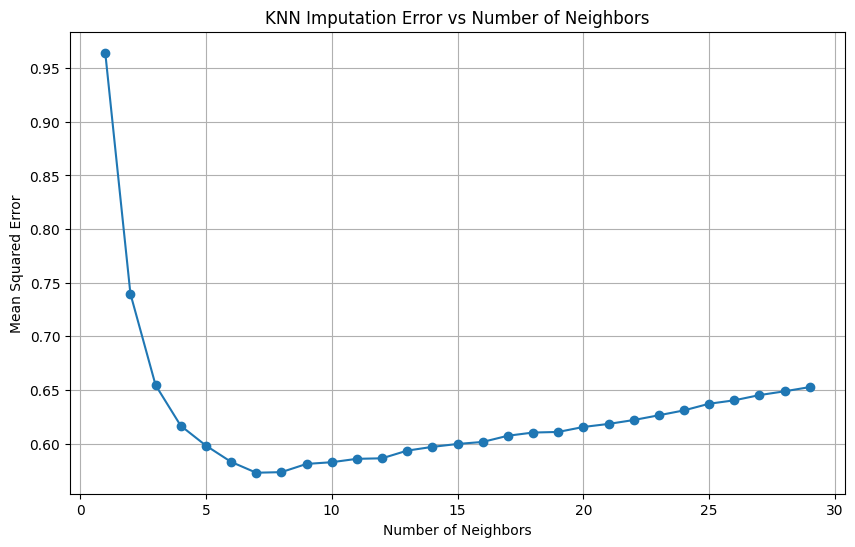

Best number of neighbors: 7


In [3]:
def impute_cat(all):
    split = np.split(all, [95,120], axis=1)
    all = split[0]
    split_cat = split[1]

    non_nans = np.sum(~np.isnan(split_cat), axis=0)
    sum_rows = np.nansum(split_cat, axis=0)/non_nans

    sum_rows = np.reshape(sum_rows,(5,5))
    sum_rows = (sum_rows == sum_rows.max(axis=1)[:,None]).astype(int)
    
    sum_rows = np.reshape(sum_rows,(25))
    nan_rows_mask = np.isnan(split_cat).any(axis=1)
    split_cat[nan_rows_mask] = sum_rows

    return np.concatenate((all, split_cat), axis=1)




def knn_cv_imputation(X, neighbors_range=list(range(1, 30)), test_size=0.2, random_state=42, plot=False):
    """
    Perform KNN imputation with cross validation to find optimal number of neighbors
    
    Parameters:
    -----------
    X : numpy.ndarray
        Input data array with missing values (NaNs)
    neighbors_range : list, optional
        Range of neighbor values to test, defaults to range(1, 30)
    test_size : float, optional
        Test set size for validation, defaults to 0.2
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    tuple
        (best_n_neighbors, X_imputed, errors)
        - best_n_neighbors: optimal number of neighbors
        - X_imputed: imputed data using best_n_neighbors
        - errors: list of MSEs for each number of neighbors
    """



    X = impute_cat(X)
    # Create a mask of non-NaN values
    # mask = ~np.isnan(X)
    nan_mask = np.isnan(X)
    n_missing = np.sum(nan_mask)
    print(f"Number of missing values: {n_missing}")

    # Create artificial test set by randomly marking some of the known values as missing
    X_train, X_valid = train_test_split(X, test_size=test_size, random_state=random_state)

    # Track errors for different numbers of neighbors
    errors = []

    for n_neighbors in neighbors_range:
        # Create artificial NaNs in validation set (only where values are known)
        X_valid_with_artificial_nans = X_valid.copy()
        # Make a mask where data is not NaN in validation set
        valid_mask = ~np.isnan(X_valid)
        # Choose random positions to set as NaN for validation
        np.random.seed(random_state)
        rows, cols = np.where(valid_mask)
        n_artificial = min(len(rows), 1000)  # Limit to avoid too many artificial NaNs
        indices = np.random.choice(len(rows), n_artificial, replace=False)
        artificial_nan_rows = rows[indices]
        artificial_nan_cols = cols[indices]
        # Store true values and set them to NaN
        true_values = X_valid_with_artificial_nans[artificial_nan_rows, artificial_nan_cols].copy()
        X_valid_with_artificial_nans[artificial_nan_rows, artificial_nan_cols] = np.nan
        
        # Fit imputer on training data and transform validation data
        imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
        imputer.fit(X_train)
        X_valid_imputed = imputer.transform(X_valid_with_artificial_nans)
        
        # Calculate error on artificially created NaNs
        imputed_values = X_valid_imputed[artificial_nan_rows, artificial_nan_cols]
        mse = mean_squared_error(true_values, imputed_values)
        errors.append(mse)
    # Plot errors vs. number of neighbors
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(neighbors_range, errors, 'o-')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Mean Squared Error')
        plt.title('KNN Imputation Error vs Number of Neighbors')
        plt.grid(True)
        plt.show()

    # Choose the best number of neighbors
    best_n_neighbors = neighbors_range[np.argmin(errors)]
    print(f"Best number of neighbors: {best_n_neighbors}")

    
    return best_n_neighbors

best_n_neighbors= knn_cv_imputation(X_merged_stand, neighbors_range=range(1, 30), test_size=0.2,plot=True)

imputer = KNNImputer(n_neighbors=best_n_neighbors)
X_merged_imputed_stand = imputer.fit_transform(X_merged_stand,y)


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional: for progress tracking

def bootstrap_rmse_knn(best_n, X, y, n_iterations=1000, test_size=0.2, random_state=42):
    """
    Bootstrap estimation of RMSE mean and confidence intervals.
    
    Parameters:
    -----------
    model : sklearn estimator object
        The model to evaluate
    X : array-like
        Feature data
    y : array-like
        Target data
    n_iterations : int
        Number of bootstrap iterations
    test_size : float
        Proportion of data to use for test set
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Results including mean RMSE and confidence intervals
    """
    # Split data into training and test sets

    X = impute_cat(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    
    #lists
    bootstrap_rmse_scores = []
    y_hat = []
    res = []


    # For progress tracking
    iterator = tqdm(range(n_iterations)) if tqdm else range(n_iterations)
    
    for _ in iterator:
        # Bootstrap sampling (with replacement)
        indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[indices]
        y_bootstrap = y_train[indices]

        

        # Create artificial NaNs in validation set (only where values are known)
        X_valid_with_artificial_nans = X_test.copy()
        # Make a mask where data is not NaN in validation set
        valid_mask = ~np.isnan(X_test)
        # Choose random positions to set as NaN for validation
        np.random.seed(random_state)
        rows, cols = np.where(valid_mask)
        n_artificial = min(len(rows), 10)  # Limit to avoid too many artificial NaNs
        indices = np.random.choice(len(rows), n_artificial, replace=False)
        artificial_nan_rows = rows[indices]
        artificial_nan_cols = cols[indices]
        # Store true values and set them to NaN
        true_values = X_valid_with_artificial_nans[artificial_nan_rows, artificial_nan_cols].copy()
        X_valid_with_artificial_nans[artificial_nan_rows, artificial_nan_cols] = np.nan

        
        # Train model on bootstrap sample
        model_clone = KNNImputer(n_neighbors=best_n, weights='distance')
        model_clone.fit(X_bootstrap)
        
        # Predict on test set
        y_pred = model_clone.transform(X_valid_with_artificial_nans)

        imputed_values = y_pred[artificial_nan_rows, artificial_nan_cols]
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
        bootstrap_rmse_scores.append(rmse)
        y_hat.append(y_pred)
        res.append((true_values-imputed_values)**2)
    
    # Calculate statistics
    mean_rmse = np.mean(bootstrap_rmse_scores)
    std_rmse = np.std(bootstrap_rmse_scores)
    
    # 95% confidence interval
    lower_ci = np.percentile(bootstrap_rmse_scores, 2.5)
    upper_ci = np.percentile(bootstrap_rmse_scores, 97.5)
    
    results = {
        'bootstrap_samples': bootstrap_rmse_scores,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'rmse_95_ci': (lower_ci, upper_ci),
        "res":  res,
        "y_pred": y_hat
    }
    
    return results
results = bootstrap_rmse_knn(best_n_neighbors, X_merged, y, n_iterations=1000, test_size=0.2, random_state=42)
print("Mean RMSE:", results['mean_rmse'])
print("95% CI:", results['rmse_95_ci'])
print("RMSE std:", results['std_rmse'])


100%|██████████| 1000/1000 [00:20<00:00, 49.10it/s]

Mean RMSE: 3.5101754492237207
95% CI: (np.float64(3.51017544922372), np.float64(3.51017544922372))
RMSE std: 8.881784197001252e-16


Fitting 5 folds for each of 2601 candidates, totalling 13005 fits
Best parameters: [('elastic_net__alpha', 1.2022644346174132), ('elastic_net__l1_ratio', 1.0)]
Best negative MSE: -798.6794453588437
Best R² score: 0.8617475195072112

Top 10 parameter combinations:
                                                 params  mean_test_score  \
1784  {'elastic_net__alpha': 1.2022644346174132, 'el...      -798.679445   
1835  {'elastic_net__alpha': 1.584893192461114, 'ela...      -819.232096   
1733  {'elastic_net__alpha': 0.9120108393559097, 'el...      -819.248627   
1682  {'elastic_net__alpha': 0.6918309709189363, 'el...      -827.452366   
1631  {'elastic_net__alpha': 0.5248074602497723, 'el...      -835.766314   
1580  {'elastic_net__alpha': 0.3981071705534969, 'el...      -849.325636   
1630  {'elastic_net__alpha': 0.5248074602497723, 'el...      -852.100581   
1579  {'elastic_net__alpha': 0.3981071705534969, 'el...      -852.380425   
1528  {'elastic_net__alpha': 0.3019951720402016, 'el

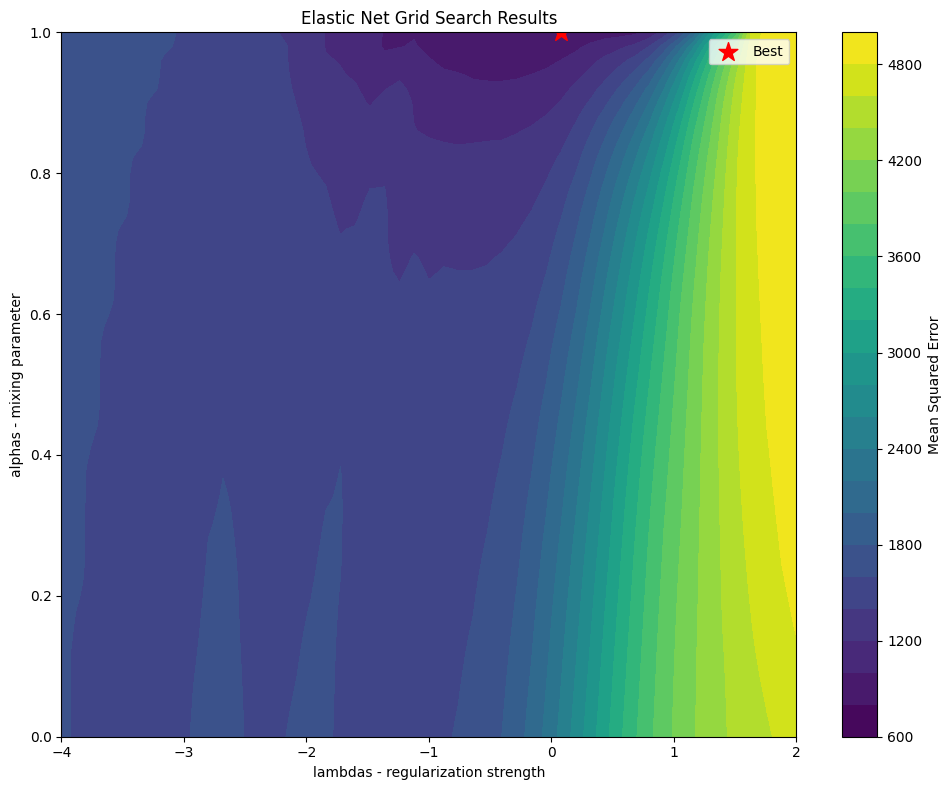


Example prediction using best model:
MSE: 902.1826198224751
R²: 0.8617475195072112
Number of betas used 36
Total number of betas 120


In [5]:
lambdas = np.logspace(-4, 2, num=51)
alphas = np.linspace(0, 1, num=51)

pipline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=best_n_neighbors)),
    ('elastic_net', linear_model.ElasticNet())])
param_grid = {
    'elastic_net__alpha': lambdas,
    'elastic_net__l1_ratio': alphas}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(pipline,
                                                    param_grid,
                                                    cv=kf,
                                                    scoring='neg_mean_squared_error',
                                                    n_jobs=-1,
                                                    verbose=1)
# Print results
X_merged_imputed = impute_cat(X_merged)
X_train, X_test, y_train, y_test = train_test_split(X_merged_imputed, y, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)
print("Best parameters:", [(k, float(grid_search.best_params_[k])) for k in grid_search.best_params_])
print("Best negative MSE:", grid_search.best_score_)
print("Best R² score:", r2_score(y_test, grid_search.predict(X_test)))

# Display top 10 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
print("\nTop 10 parameter combinations:")
cols_to_display = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print(results_df[cols_to_display].head(10))



# Plot results (optional)
try:
    import matplotlib.pyplot as plt
    from matplotlib import cm
    
    # Extract unique values of alpha and l1_ratio
    alphas = sorted(set([params['elastic_net__alpha'] for params in results_df['params']]))
    l1_ratios = sorted(set([params['elastic_net__l1_ratio'] for params in results_df['params']]))
    
    # Create a meshgrid for the plot
    alpha_mesh, l1_ratio_mesh = np.meshgrid(np.log10(alphas), l1_ratios)
    
    # Create a matrix of scores
    scores = np.zeros(alpha_mesh.shape)
    for i, l1_ratio in enumerate(l1_ratios):
        for j, alpha in enumerate(alphas):
            row = results_df[
                (results_df['param_elastic_net__alpha'] == alpha) & 
                (results_df['param_elastic_net__l1_ratio'] == l1_ratio)
            ]
            if not row.empty:
                scores[i, j] = row['mean_test_score'].values[0]
    
    # Convert negative MSE to positive for better visualization
    scores = -scores
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(alpha_mesh, l1_ratio_mesh, scores, cmap=cm.viridis, levels=20)
    ax.set_xlabel('lambdas - regularization strength')
    ax.set_ylabel('alphas - mixing parameter')
    ax.set_title('Elastic Net Grid Search Results')
    plt.colorbar(contour, label='Mean Squared Error')
    
    # Mark the best point
    best_alpha = grid_search.best_params_['elastic_net__alpha']
    best_l1_ratio = grid_search.best_params_['elastic_net__l1_ratio']
    ax.scatter(np.log10(best_alpha), best_l1_ratio, color='red', marker='*', s=200, label='Best')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('elastic_net_grid_search_results.png')
    plt.show()
    
except ImportError:
    print("Matplotlib not available for plotting. Install with 'pip install matplotlib'")

# Example of using the best model
Lambda = grid_search.best_params_['elastic_net__alpha']
Alpha = grid_search.best_params_['elastic_net__l1_ratio']

best_model = grid_search.best_estimator_
print("\nExample prediction using best model:")
predictions = best_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))
print("R²:", r2_score(y_test,predictions))
betas = best_model.named_steps['elastic_net'].coef_
print("Number of betas used", np.sum([1 for beta in betas if beta != 0]))
print("Total number of betas" , len(betas))


One Standard Error Rule Selection:
Best model params: {'elastic_net__alpha': np.float64(1.2022644346174132), 'elastic_net__l1_ratio': np.float64(1.0)}
One SE model params: {'elastic_net__alpha': np.float64(4.7863009232263805), 'elastic_net__l1_ratio': np.float64(1.0)}

One SE Model Performance:
MSE: 1007.1914465785778
R²: 0.8456557322640414
Number of features in best model: 36
Number of features in one SE model: 11


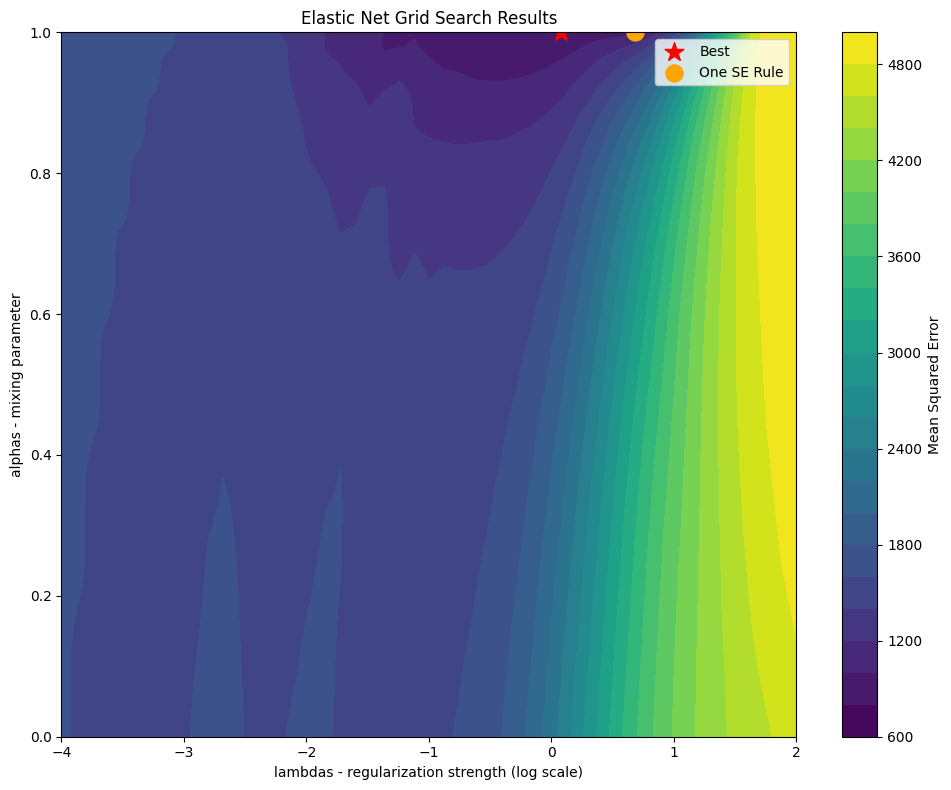

No simpler model found within one standard error


In [6]:
# Apply the one standard error rule to find a simpler model
best_score = grid_search.best_score_
best_std = results_df.loc[results_df['rank_test_score'] == 1, 'std_test_score'].values[0]
threshold = best_score - best_std  # One standard error below the best score

# Find the simplest model within one standard error of the best model
# For elastic net, simpler models have higher alpha (stronger regularization)
simpler_models = results_df[results_df['mean_test_score'] >= threshold].sort_values(
    by=['param_elastic_net__alpha', 'param_elastic_net__l1_ratio'], 
    ascending=[False, True]  # Prioritize higher alpha (more regularization)
)

if not simpler_models.empty:
    one_se_model_params = simpler_models.iloc[0]['params']
    print("\nOne Standard Error Rule Selection:")
    print(f"Best model params: {grid_search.best_params_}")
    print(f"One SE model params: {one_se_model_params}")
    
    # Create and evaluate the one SE model
    one_se_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=best_n_neighbors)),
        ('elastic_net', linear_model.ElasticNet(
            alpha=one_se_model_params['elastic_net__alpha'],
            l1_ratio=one_se_model_params['elastic_net__l1_ratio']
        ))])
    
    one_se_pipeline.fit(X_train, y_train)
    one_se_preds = one_se_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, one_se_preds)
    print("\nOne SE Model Performance:")
    print("MSE:", mse)
    print("R²:", r2_score(y_test, one_se_preds))
    
    # Compare feature counts
    one_se_betas = one_se_pipeline.named_steps['elastic_net'].coef_
    print("Number of features in best model:", np.sum([1 for beta in betas if beta != 0]))
    print("Number of features in one SE model:", np.sum([1 for beta in one_se_betas if beta != 0]))
    
    # Optional: Plot both models on the contour plot
    Alpha = one_se_model_params['elastic_net__l1_ratio']
    Lambda = one_se_model_params['elastic_net__alpha']
try:
    import matplotlib.pyplot as plt
    from matplotlib import cm
    
    # Extract unique values of alpha and l1_ratio
    alphas = sorted(set([params['elastic_net__alpha'] for params in results_df['params']]))
    l1_ratios = sorted(set([params['elastic_net__l1_ratio'] for params in results_df['params']]))
    
    # Create a meshgrid for the plot
    alpha_mesh, l1_ratio_mesh = np.meshgrid(np.log10(alphas), l1_ratios)
    
    # Create a matrix of scores
    scores = np.zeros(alpha_mesh.shape)
    for i, l1_ratio in enumerate(l1_ratios):
        for j, alpha in enumerate(alphas):
            row = results_df[
                (results_df['param_elastic_net__alpha'] == alpha) & 
                (results_df['param_elastic_net__l1_ratio'] == l1_ratio)
            ]
            if not row.empty:
                scores[i, j] = row['mean_test_score'].values[0]
    
    # Convert negative MSE to positive for better visualization
    scores = -scores
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(alpha_mesh, l1_ratio_mesh, scores, cmap=cm.viridis, levels=20)
    ax.set_xlabel('lambdas - regularization strength (log scale)')
    ax.set_ylabel('alphas - mixing parameter')
    ax.set_title('Elastic Net Grid Search Results')
    plt.colorbar(contour, label='Mean Squared Error')
    
    # Mark the best point
    best_alpha = grid_search.best_params_['elastic_net__alpha']
    best_l1_ratio = grid_search.best_params_['elastic_net__l1_ratio']
    ax.scatter(np.log10(best_alpha), best_l1_ratio, color='red', marker='*', s=200, label='Best')
    ax.scatter(
        np.log10(one_se_model_params['elastic_net__alpha']), 
        one_se_model_params['elastic_net__l1_ratio'], 
        color='orange', marker='o', s=150, label='One SE Rule'
    )
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('elastic_net_grid_search_results.png')
    plt.show()
    
except ImportError:
    print("Matplotlib not available for plotting. Install with 'pip install matplotlib'")

else:
    print("No simpler model found within one standard error")


[np.float64(0.0), np.float64(0.02), np.float64(0.04), np.float64(0.06), np.float64(0.08), np.float64(0.1), np.float64(0.12), np.float64(0.14), np.float64(0.16), np.float64(0.18), np.float64(0.2), np.float64(0.22), np.float64(0.24), np.float64(0.26), np.float64(0.28), np.float64(0.3), np.float64(0.32), np.float64(0.34), np.float64(0.36), np.float64(0.38), np.float64(0.4), np.float64(0.42), np.float64(0.44), np.float64(0.46), np.float64(0.48), np.float64(0.5), np.float64(0.52), np.float64(0.54), np.float64(0.56), np.float64(0.58), np.float64(0.6), np.float64(0.62), np.float64(0.64), np.float64(0.66), np.float64(0.68), np.float64(0.7000000000000001), np.float64(0.72), np.float64(0.74), np.float64(0.76), np.float64(0.78), np.float64(0.8), np.float64(0.8200000000000001), np.float64(0.84), np.float64(0.86), np.float64(0.88), np.float64(0.9), np.float64(0.92), np.float64(0.9400000000000001), np.float64(0.96), np.float64(0.98), np.float64(1.0)]


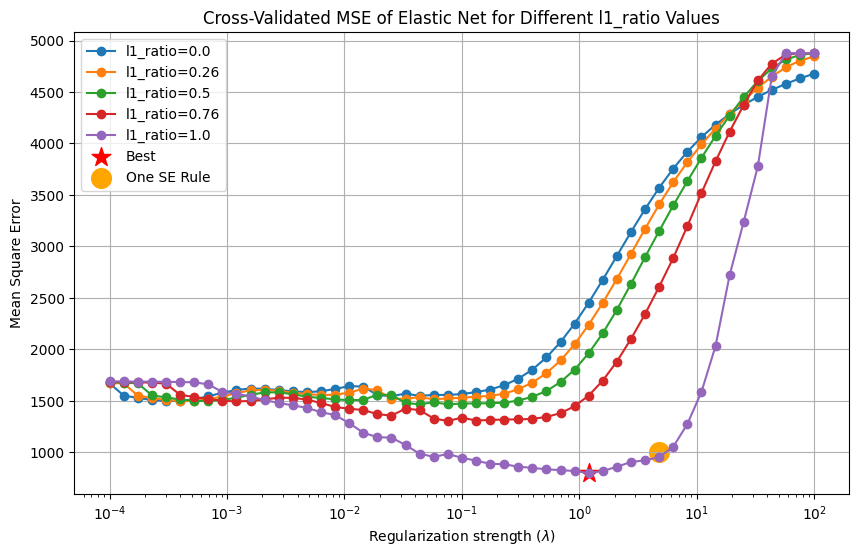

In [7]:
# Extract regularization parameters and scores from grid search results
results_df = pd.DataFrame(grid_search.cv_results_)

# Get unique alpha values (sorted)
alphas = sorted(set([params['elastic_net__l1_ratio'] for params in results_df['params']]))

# Set up the plot
plt.figure(figsize=(10, 6))

# For each l1_ratio value, plot a line showing how MSE changes with alpha
for l1_ratio in [0.0, 0.26, 0.5, 0.76, 1.0]:
    # Filter results for this l1_ratio
    ratio_df = results_df[results_df['param_elastic_net__l1_ratio'] == l1_ratio]
    if not ratio_df.empty:
        # Sort by alpha
        ratio_df = ratio_df.sort_values('param_elastic_net__alpha')
        # Plot negative MSE (convert back to positive for visualization)
        plt.semilogx(
            ratio_df['param_elastic_net__alpha'],
            -ratio_df['mean_test_score'],
            label=f'l1_ratio={l1_ratio}',
            marker='o'
        )

# Highlight the best parameter
best_alpha = grid_search.best_params_['elastic_net__alpha']
best_l1_ratio = grid_search.best_params_['elastic_net__l1_ratio']
best_mse = -grid_search.best_score_

plt.scatter(best_alpha, best_mse, color='red', marker='*', s=200, label='Best')
plt.scatter(Lambda, mse, color='orange', marker='o', s=200, label='One SE Rule')




plt.xlabel(r'Regularization strength ($\lambda$)')
plt.ylabel('Mean Square Error')
plt.title('Cross-Validated MSE of Elastic Net for Different l1_ratio Values')
plt.legend()
plt.grid(True)
print (alphas)

In [8]:
# dtree = DecisionTreeRegressor()
# cv_grid = GridSearchCV(estimator=dtree, param_grid={'max_depth': range(1, 120),
#                                                     "ccp_alpha":np.linspace(0,1,num=50),
#                                                     "min_samples_leaf":range(2,21),
#                                                     "criterion":["squared_error"]}, cv=5, scoring='neg_mean_squared_error',verbose=1)
# cv_grid.fit(X_train, y_train)
# print("Best parameters:", cv_grid.best_params_)
# print("MSE", mean_squared_error(y_test, cv_grid.predict(X_test)))



In [9]:
# from sklearn.ensemble import RandomForestRegressor
# # Make a randomforrest classifier. Try to experiment with criterion, number of estimators, max_depth, min_samples_leaf
# clf = RandomForestRegressor()
# X_train, X_test, y_train, y_test = train_test_split(X_merged_imputed_stand, y, test_size=0.2, random_state=42)


# # use GridSearchCV to find the best model
# # Define parameters to change and the values to try
# # I suggest using a very small grid as it takes a long time to run otherwise
# # Try implementing a small grid and then use the attached results for the discusion

# params = {
#     'n_estimators': [400, 600, 800, 1000],
#     'criterion': ['friedman_mse', 'absolute_error', 'squared_error'],
#     'max_depth': [50, 60, 70],
#     # 'min_samples_leaf': [ 10, 50],
#     'max_features': list(range(30, 70,10))
# }
# rf_grid = GridSearchCV(clf, params, cv=5, n_jobs=-1,verbose=3)

# # Fit the grid search model
# rf_grid.fit(X_train, y_train)

# print(rf_grid.best_estimator_)
# print("MSE", mean_squared_error(y_test, rf_grid.predict(X_test)))
# print("R²:", r2_score(y_test, rf_grid.predict(X_test)))


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional: for progress tracking

def bootstrap_rmse(lamb, alpha, X, y, n_iterations=1000, test_size=0.2, random_state=42):
    """
    Bootstrap estimation of RMSE mean and confidence intervals.
    
    Parameters:
    -----------
    model : sklearn estimator object
        The model to evaluate
    X : array-like
        Feature data
    y : array-like
        Target data
    n_iterations : int
        Number of bootstrap iterations
    test_size : float
        Proportion of data to use for test set
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Results including mean RMSE and confidence intervals
    """
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    bootstrap_rmse_scores = []
    y_hat = []
    res = []
    
    # For progress tracking
    iterator = tqdm(range(n_iterations)) if tqdm else range(n_iterations)
    
    for _ in iterator:
        # Bootstrap sampling (with replacement)
        indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[indices]
        y_bootstrap = y_train[indices]
        
        # Train model on bootstrap sample
        model_clone = linear_model.ElasticNet(alpha=lamb, l1_ratio=alpha) 
        model_clone.fit(X_bootstrap, y_bootstrap)
        
        # Predict on test set
        y_pred = model_clone.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        bootstrap_rmse_scores.append(rmse)
        y_hat.append(y_pred)
        res.append((y_test-y_pred)**2)
    
    # Calculate statistics
    mean_rmse = np.mean(bootstrap_rmse_scores)
    std_rmse = np.std(bootstrap_rmse_scores)
    
    # 95% confidence interval
    lower_ci = np.percentile(bootstrap_rmse_scores, 2.5)
    upper_ci = np.percentile(bootstrap_rmse_scores, 97.5)
    
    results = {
        'bootstrap_samples': bootstrap_rmse_scores,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'rmse_95_ci': (lower_ci, upper_ci),
        "res":  res,
        "y_pred": y_hat
    }
    
    return results
results = bootstrap_rmse(Lambda, Alpha, X_merged_imputed_stand, y, n_iterations=1000, test_size=0.2, random_state=42)
print("Mean RMSE:", results['mean_rmse'])
print("95% CI:", results['rmse_95_ci'])
print("RMSE std:", results['std_rmse'])


100%|██████████| 1000/1000 [00:01<00:00, 899.04it/s]

Mean RMSE: 35.58623489318763
95% CI: (np.float64(30.298931897709412), np.float64(42.64461479997648))
RMSE std: 3.21812125336636


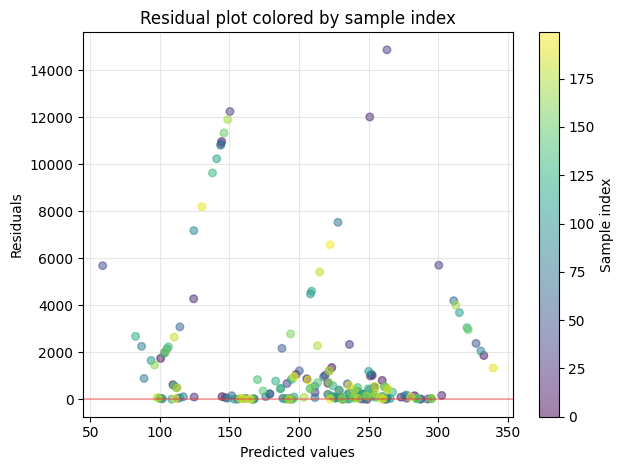

In [11]:
y_pred = np.array(results['y_pred']).flatten()
res = np.array(results['res']).flatten()

frac = len(y_pred)//100

# Create a figure with a reasonable size

# Create points colored by their order
indices = np.arange(len(y_pred))[:frac]
scatter = plt.scatter(y_pred[:frac], res[:frac], 
                     c=indices,      # Color by index
                     alpha=0.5, 
                     cmap='viridis', # Use viridis colormap
                     s=30)           # Point size

# Add a color bar to show the relationship between color and index
cbar = plt.colorbar(scatter)
cbar.set_label('Sample index')

# Add labels and title
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot colored by sample index')

# Add a horizontal line at y=0 to highlight the zero residual line
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()